In [225]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Load, scale and normalize the data:
data = np.loadtxt('ex2data1.txt', delimiter=',')

# `fminunc` >  `Scipy.optimize.minimize`

It took a confused Stack [Overflow thread](https://stackoverflow.com/questions/38465959/scipy-minimize-with-gradient/38525804#38525804) and a few evenings to figure out the correct way to call `minimize` and then debug the algorithm's failure to converge. The [SciPy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) are not as complete as they could be, but the real problem was understanding why the algo wasn't converging. Adding debugging messages into the cost function showed that the call to `np.power(np.e, -z)` was overflowing almost immediately. `Z` can get quite large, and I suspect `np.power` is a wrapper to a C function. Interesting, though, none of this is an issue with Octave's `fminunc`. 

Fortunately, feature scaling and normalization fixes the problem. 

In [226]:
X_initial = data.copy()
X_initial = X_initial[:, 0:2]
X_initial[:, 0] -= X_initial[:, 0].mean()
X_initial[:, 0] /= X_initial[:, 0].std()
X_initial[:, 1] -= X_initial[:, 1].mean()
X_initial[:, 1] /= X_initial[:, 1].std()
y = data[:, 2]

# Feature scaling and regularizing doesn't change the way the data "looks":

The structural relationship of the data isn't affected by feature scaling, but obviously the statistical properties of the data are completely changed:

## Unscaled:

44.1554240485
34.4611962735
1187.5740486


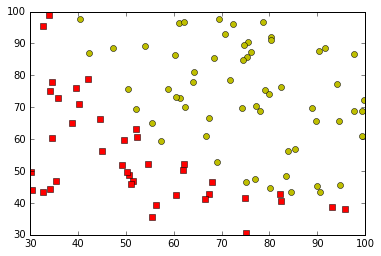

In [227]:
positive_unscaled = data[data[:, 2] == 1, :]
plt.plot(positive_unscaled[:, 0], positive_unscaled[:, 1], 'yo')
negative_unscaled = data[data[:, 2] == 0, :]
plt.plot(negative_unscaled[:, 0], negative_unscaled[:, 1], 'rs')

print data.mean()
print data.std()
print data.var()

## Scaled: 

5.24025267623e-16
1.0
1.0


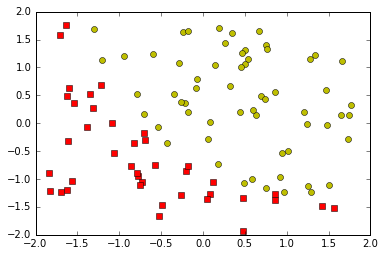

In [228]:
positive = X_initial[y == 1, :]
plt.plot(positive[:, 0], positive[:, 1], 'yo')
negative = X_initial[y == 0, :]
plt.plot(negative[:, 0], negative[:, 1], 'rs')

print X_initial.mean()
print X_initial.std()
print X_initial.var()

0.441554240485
0.344611962735
0.11875740486


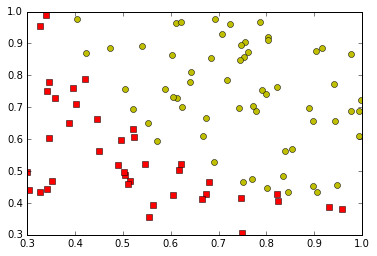

In [229]:
# Divide by 10 as a comparison:
X_div = data.copy()
X_div /= 100

positive_divided = X_div[y == 1, :]
plt.plot(positive_divided[:, 0], positive_divided[:, 1], 'yo')

negative_divided = X_div[data[:, 2] == 0, :]
plt.plot(negative_divided[:, 0], negative_divided[:, 1], 'rs')

print X_div.mean()
print X_div.std()
print X_div.var()

In [230]:
def sigmoid(z):
    return 1/(1 + np.power(np.e, -z))

h = lambda theta, x: sigmoid(x.dot(theta))


def cost(theta, X, y, lambd=0, debug=False, **kwargs):
    """ Logistic regression cost function with optional regularization. `Lambd` is the regularization constant. """
    m = X.shape[0]
    j = y.dot(np.log(h(theta, X)))  + (1 - y).dot(np.log(1 - h(theta, X)))
    regularization = (float(lambd)/float(2*m)) * theta[1:].dot(theta[1:].T)
    j /= -m
    j += regularization
    return j


def grad(theta, X, y, lambd=0, **kwargs):
    m = X.shape[0]
    regularization_theta = theta.copy()
    regularization_theta[0] = 0
    return ((h(theta, X) - y).dot(X))/m + (float(lambd)/m)*regularization_theta.astype(float)

# Add a column of ones:
m, features = np.shape(X_initial)
features += 1
X = np.concatenate([np.ones((m, 1)), X_initial], axis=1)
initial_theta = np.zeros((features))


def check_functions(grad_func, cost_func):
    '''
    Asserts that the cost and gradient functions return known corret values for a given theta, X, y.  
    Test case from https://www.coursera.org/learn/machine-learning/discussions/weeks/3/threads/tA3ESpq0EeW70BJZtLVfGQ
    The expected cost is 4.6832.
    The expected gradient = [0.31722, 0.87232, 1.64812, 2.23787]
    '''
    test_X = np.array([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])  # X
    test_y = np.array([[1, 0, 1]])  # y
    test_theta = np.array([-2, -1, 1, 2])
    
    grad_diff = grad_func(test_theta, test_X, test_y) - np.array([0.31722, 0.87232, 1.64812, 2.23787])
    assert grad_diff.dot(grad_diff.T) < 0.0001
    assert abs(cost_func(test_theta, test_X, test_y, debug=False) - 4.6832) < 0.0001
    
check_functions(grad, cost)
minimization_result = minimize(fun=cost, x0=initial_theta, args=(X, y), jac=grad)

The scaled and normalized data set gives the correct answer. If you just naively divide the dataset by a constant factor, you need to divide by ~100 to get `minimize` to converge, and it yields the wrong answer. 

In [231]:
def divide_data_theta():
    """ The optimization result is incorrect if you just divide the dataset by a constant. """
    div_result = minimize(fun=cost, x0=initial_theta, args=(X_div, y), jac=grad)
    print div_result
    print cost(div_result.x, X_div, y)

cost(minimization_result.x, X, y)

0.20349770235115472

# Ploting the decision boundary

To plot the linear decision boundary we want to find the equation for the line: 

$${\theta_1}x_1 + {\theta_2}x_2 + {\theta_3}x_3 = 0$$ 

$x_1$ is a bias unit and set to 1. We can arbitrarily pick an $x$ to solve for. Picking $x_3$ and rearranging we get:

$$ x_3 = -\frac{{\theta_2}x_2 + {\theta_1}}{\theta_3}  $$

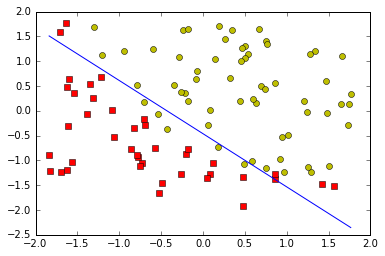

In [232]:
# We omit the first column because those are the 1s that we appended onto X:
plt.plot(positive[:, 0], positive[:, 1], 'yo')
plt.plot(negative[:, 0], negative[:, 1], 'rs')

plot_x = np.array([np.min(X[:,1]),  np.max(X[:,1])])
theta = minimization_result.x
plot_y = (-1/theta[2]) * (theta[1] * plot_x + theta[0]);
plt.plot(plot_x, plot_y)


# Accuracy

In [233]:
model = lambda x: x.dot(minimization_result.x)
predictions = np.round(sigmoid(model(X)))

total_correct = sum(predictions == y)
assert float(total_correct) / float(y.shape[0]) == 0.89
print 'Percentage correctly predicted: 89%, as expected.' 

Percentage correctly predicted: 89%, as expected.


# Nonlinear classification & Feature Mapping

Our next data set isn't linearly seperable, and only has two features, so we are going to create a number of polynomial features in order to find a classifier for it.

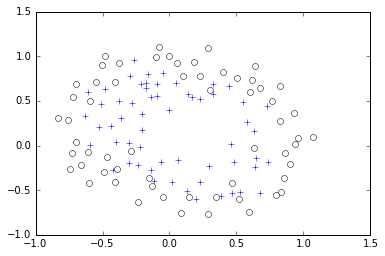

In [234]:
def map_features(X):
    """ 
    Given X, our two-feature array of x1 & x2, returns a new np array with polynomial feature: 
    x1, x2, x1^2, x2^, x1*x2, x1*x2^2, x1^2*x2, etc... up to the 6th degree. 
    """
    x1 = X[:, 0]
    x2 = X[:, 1]
    degree = 6
    output = np.ones((x1.shape[0], 1))
    for i in range(1, degree+1):
        for j in range(i+1):
            rows, columns = output.shape
            output = np.concatenate([output, np.zeros((rows, 1))], axis=1)
            output[:, columns] = np.power(x1, i - j) * np.power(x2, j)
    return output

data2 = np.loadtxt('ex2data2.txt', delimiter=',')
X2_initial = data2[:, 0:2]
y2 = data2[:, 2]

polynomial_X = map_features(X2_initial)

positive = X2_initial[y2 == 1]
plt.plot(positive[:, 0], positive[:, 1], '+')

negative = X2_initial[y2 == 0]
plt.plot(negative[:, 0], negative[:, 1], 'wo')

In [235]:
rows, features = polynomial_X.shape
initial_theta = np.zeros((features))
regularization = 1  # Lambda value
print cost(initial_theta, polynomial_X, y2, lambd=regularization)

0.69314718056


In [249]:
def curried_cost(theta, X, y):
    return cost(theta, X, y, lambd=1)

def curried_grad(theta, X, y):
    return grad(theta, X, y, lambd=1)

minimization_result = minimize(fun=curried_cost, x0=initial_theta, args=(polynomial_X, y2), jac=curried_grad, tol=0.0000001)

In [251]:
# As a sanity check, I've grabbed the value fminunc computes in ex2 for theta and compared the two vectors...
octave_theta = np.array([1.2308e+00, 6.2746e-01, 1.2244e+00, -2.0028e+00, -6.7719e-01, -1.1363e+00, 5.3377e-02, -3.0588e-01, -2.8833e-01, -2.3607e-01, -1.5155e+00, -6.2719e-02, -5.6782e-01, -1.8009e-01, -1.2011e+00, -3.0469e-01, -1.9685e-01, -7.0687e-02, -2.4604e-01, -2.2396e-01, -6.5167e-01, -1.1139e+00, -3.6856e-04, -2.8302e-01, 1.9365e-03, -3.0873e-01, -8.3980e-02, -1.1066e+00])
diff = minimization_result.x - octave_theta
diff.dot(diff.T)

# Hmm.. this is a fairly large difference from what Octave finds, but possibly due to numerical issues..

0.27264680398166719

# The nonlinear decision boundary

Similarly to how we plotted the parabolic error surface in ex1, we can use a grid search to find points on 'decision surface' here, and the plot the contour at z=0, which 


In [283]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((u.size, v.size))
for i, u_val in enumerate(u):
    for j, v_val in enumerate(v):        
        X = np.array([[u_val, v_val], ])
        z[i, j] = map_features(X).dot(minimization_result.x) 
        


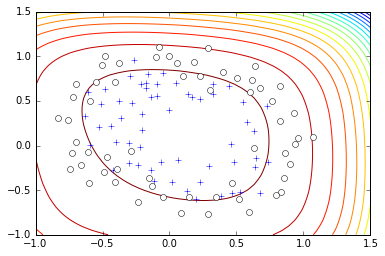

In [288]:
plt.figure()
plt.contour(u, v, z.T, 20)
plt.plot(positive[:, 0], positive[:, 1], '+')
plt.plot(negative[:, 0], negative[:, 1], 'wo')
plt.show()
